In [1]:
from llmgt.evaluation import *
import pandas as pd
import matplotlib.pyplot as plt

# Optional: Auto-reload modules if you're editing source code live
%load_ext autoreload
%autoreload 2


In [2]:
dirs = [
    get_predictions_subdir("predictions_qwen-3_inst")
]

df = build_big_df(dirs)
print(df)


                                           source_file  temperature prompt  \
0    qwen-3_inst_T1_ndet_t09_tok512_s101_output_b_v...          0.9     v1   
1    qwen-3_inst_T1_ndet_t09_tok512_s101_output_b_v...          0.9     v1   
2    qwen-3_inst_T1_ndet_t09_tok512_s101_output_b_v...          0.9     v1   
3    qwen-3_inst_T1_ndet_t09_tok512_s101_output_b_v...          0.9     v1   
4    qwen-3_inst_T1_ndet_t09_tok512_s101_output_b_v...          0.9     v1   
..                                                 ...          ...    ...   
817  qwen-3_inst_T1_ndet_t07_tok512_s42_output_b_v3...          0.7     v3   
818  qwen-3_inst_T1_ndet_t07_tok512_s42_output_b_v3...          0.7     v3   
819  qwen-3_inst_T1_ndet_t07_tok512_s42_output_b_v3...          0.7     v3   
820  qwen-3_inst_T1_ndet_t07_tok512_s42_output_b_v3...          0.7     v3   
821  qwen-3_inst_T1_ndet_t07_tok512_s42_output_b_v3...          0.7     v3   

                id gold_ne pred_nash  binary_acc  
0    IDx-002

In [33]:
print("gold_ne types:")
print(df["gold_ne"].map(type).value_counts())

print("\npred_nash types:")
print(df["pred_nash"].map(type).value_counts())


gold_ne types:
gold_ne
<class 'numpy.ndarray'>    822
Name: count, dtype: int64

pred_nash types:
pred_nash
<class 'str'>    822
Name: count, dtype: int64


In [28]:
from sklearn.metrics import confusion_matrix


In [35]:
df["pred_nash"].value_counts()


pred_nash
TL     603
TB     217
B,R      1
T,L      1
Name: count, dtype: int64

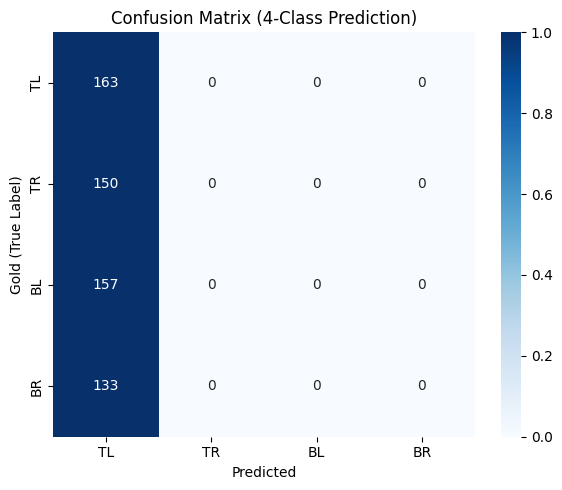

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["TL", "TR", "BL", "BR"]

# Flatten golds if needed
df["gold_ne_flat"] = df["gold_ne"].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)

golds = df["gold_ne_flat"]
preds = df["pred_nash"]

cm = confusion_matrix(golds, preds, labels=labels)
cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=cm, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Gold (True Label)")
plt.title("Confusion Matrix (4-Class Prediction)")
plt.tight_layout()
plt.show()


In [4]:
# Overall accuracy
overall_acc = df["binary_acc"].mean()
print(f"Overall accuracy: {overall_acc:.3f}")

# Accuracy by prompt version
df.groupby("prompt")["binary_acc"].mean().sort_values(ascending=False)


Overall accuracy: 0.198


prompt
v1    0.256198
v3    0.241279
v2    0.137255
Name: binary_acc, dtype: float64

In [10]:
from statsmodels.stats.contingency_tables import cochrans_q
mat = (
    df[df["prompt"] == "v1"]
    .pivot(index="id", columns="temperature", values="binary_acc")
    .dropna()
)

result = cochrans_q(mat)
print(f"Cochran’s Q = {result.statistic:.2f},  p = {result.pvalue:.4g}")



Cochran’s Q = 1.00,  p = 0.3173


<Axes: title={'center': 'Mean Accuracy by Temperature'}, xlabel='temperature'>

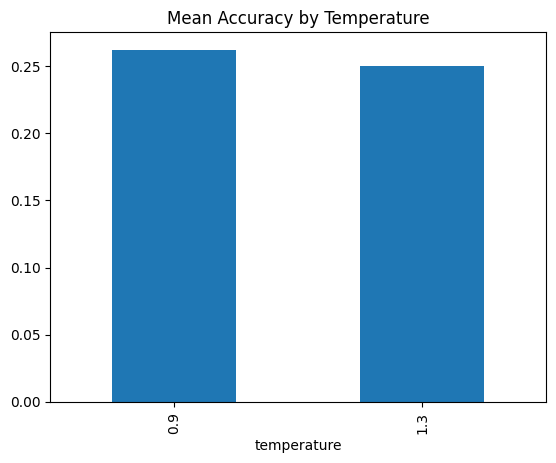

In [11]:
(df[df["prompt"] == "v1"]
 .groupby("temperature")["binary_acc"]
 .mean()
 .plot(kind="bar", title="Mean Accuracy by Temperature"))


In [18]:
# Sanity check: how many examples per group?
df.groupby(["prompt", "temperature"]).size()

df.groupby(["prompt", "temperature", "binary_acc"]).size().unstack(fill_value=0)


binary_acc           0   1
prompt temperature        
v1     0.9          45  16
       1.3          45  15
v2     0.7          84  12
       0.9          80  11
       1.1          74  14
       1.3          70  12
v3     0.7          69  22
       0.9          67  21
       1.1          63  22
       1.3          62  18

In [20]:
glm = smf.glm(
    "binary_acc ~ C(prompt) * C(temperature)",
    data=df,
    family=sm.families.Binomial()
).fit()

print(glm.summary())
glm = smf.glm(
    "binary_acc ~ C(prompt) * C(temperature)",
    data=df,
    family=sm.families.Binomial()
).fit()

print(glm.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             binary_acc   No. Observations:                  822
Model:                            GLM   Df Residuals:                      812
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -401.22
Date:                Fri, 18 Apr 2025   Deviance:                       802.44
Time:                        23:01:13   Pearson chi2:                     817.
No. Iterations:                   100   Pseudo R-squ. (CS):            0.01967
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [21]:
predict_df = df[["prompt", "temperature"]].drop_duplicates()
predict_df["predicted_acc"] = glm.predict(predict_df)
predict_df

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=predict_df, x="temperature", y="predicted_acc", hue="prompt")
plt.title("Predicted Accuracy by Prompt × Temperature")
plt.ylabel("Predicted Accuracy")
plt.show()


ModuleNotFoundError: No module named 'seaborn'

In [16]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
glm = smf.glm(
    "binary_acc ~ C(prompt) * C(temperature)",
    data=df,
    family=sm.families.Binomial()
).fit(cov_type="cluster", cov_kwds={"groups": df["id"]})


print(glm.summary())
print("Odds‑ratios:\n", glm.params.apply(lambda b: f"{np.exp(b):.2f}"))


                 Generalized Linear Model Regression Results                  
Dep. Variable:             binary_acc   No. Observations:                  822
Model:                            GLM   Df Residuals:                      812
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -401.22
Date:                Fri, 18 Apr 2025   Deviance:                       802.44
Time:                        22:57:12   Pearson chi2:                     817.
No. Iterations:                   100   Pseudo R-squ. (CS):            0.01967
Covariance Type:              cluster                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [12]:
mixed = smf.mixedlm(
    "correct ~ C(prompt) * C(temperature)",
    data=big_df,
    groups="item_id",
    family=sm.families.Binomial()    # GLMM support now in statsmodels ≥ v0.14
).fit(method="bfgs")

mixed.summary()


NameError: name 'smf' is not defined

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.multitest import multipletests

def mcnemar_pair(g, p1, p2):
    tbl = (
        g[g["prompt"] == p1].set_index("item_id")["correct"]
          .to_frame("a")
          .join(g[g["prompt"] == p2].set_index("item_id")["correct"]
          .to_frame("b"))
          .dropna()
          .astype(int)
    )
    b = ((tbl["a"] == 1) & (tbl["b"] == 0)).sum()
    c = ((tbl["a"] == 0) & (tbl["b"] == 1)).sum()
    return mcnemar([[0, b], [c, 0]], exact=False, correction=True)

records = []
for T, g in big_df.groupby("temperature"):
    for p1, p2 in [("v1","v2"), ("v1","v3"), ("v2","v3")]:
        res = mcnemar_pair(g, p1, p2)
        records.append({"T":T, "pair":f"{p1} vs {p2}",
                        "chi2":res.statistic, "p":res.pvalue})

df_post = pd.DataFrame(records)
df_post["p_adj"] = df_post.groupby("T")["p"].transform(
    lambda p: multipletests(p, method="holm")[1])
print(df_post)


In [ ]:
from statsmodels.stats.proportion import proportion_confint

grp = (big_df.groupby(["prompt", "temperature"])
               ["correct"].agg(["sum", "count"]))

grp["mean"] = grp["sum"] / grp["count"]
grp[["ci_low", "ci_high"]] = grp.apply(
    lambda row: proportion_confint(row["sum"], row["count"], method="wilson"),
    axis=1, result_type="expand")
print(grp.round(3))
